### Topic modeling
Topic modeling refers to general class of techniques that separate the vector-spaces of a corpus into document-topic & topic-word relations. The first of these was latent semantic analysis. Based on singular value decomposition, it produces a linear decomposed space in which documents can be compared more effectively. Unlike LSA, the the subsequent techniques of probabalistic-LSA and latent Dirichlet allocation (LDA) do not produce linear transforms. Rather, they predict topic membership based on word inclusion in a document.

All three approaches provide a method for extracting structure from a corpus. Using Carmilla once more, let's explore LSA & LDA. This time we'll use the [gensim package](https://radimrehurek.com/gensim/auto_examples/index.html) as it provides a comprehensive toolkit for this task.

In [134]:
# import useful stuff
import numpy as np
from gensim import corpora, models, similarities

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [61]:
with open('carmilla.txt', 'r') as f:
    corp = f.read()
    
from utils.cheaters import dctConstr

dct = dctConstr(stop_words=["i", "you", "a"], ignore_case=True)
dct.constructor(corp)

In [62]:
def split_by_paragraphs(data:str) -> []:
    processed=data.lower()
    while '\n\n\n' in processed:
        processed=processed.replace('\n\n\n','\n\n')
    out = processed.split('\n\n')
    return [o.replace("\n", " ") for o in out]

pcorp = split_by_paragraphs(corp)
pbow = [dct(para) for para in pcorp]
ptfidf = [dct.tfidf(para) for para in pcorp]
pvec = [dct.bow_to_vec(p) for p in pbow]

idx_to_terms = {i:j for j, i in dct.terms.items()} # flip dictionary for reversal
print(f"The corpus consists of {len(pvec[0])} terms and {len(pcorp)} documents")

The corpus consists of 3988 terms and 676 documents


Let's construct a dictionary and bow format with gensim and compare the results.

In [63]:
stoplist = set('for a of the and to in'.split())
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in pcorp
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [64]:
len(dictionary) 
print(list(dictionary.values())[:10])
print(list(dct.terms.keys())[:10])

['carmilla', 'j.', 'lefanu', 'sheridan', '1872', 'prologue', '_upon', 'accompanies', 'attached', 'doctor']
['⊹', 'carmilla', 'j', 'sheridan', 'lefanu', '1872', 'prologue', 'upon', 'a', 'paper']


From the dictionary we can see that the terms extracted are very similar, but with some parsing artifacts in the gensim parser and the '⊹' symbol for the cheaters method. For the initial disussion, we can ignore the differences and in doing so, demonstrate the effectiveness of topic modeling in removing "noise".

Let's calculate the LSA transform, transform the corpus into the "document space", and then examine the topics. Note that latent semantic indexing (LSI) comes from the paper by Deerwester, et al. Also note that this was not the first paper, just the popular one.

Note that the SVD is not truly deterministic for sparse matrices. This non-deterministic behaviour relates to the way in which [eigenvectors are calculated](https://en.wikipedia.org/wiki/Lanczos_algorithm) by a computer.

In [77]:
np.random.seed(42) # why is it always 42???
lsa = models.LsiModel(pbow, id2word=idx_to_terms, num_topics=100)
corpus_lsa = lsa[pbow] 

print(lsa.print_topic(0, 30))
print()
print(lsa.print_topic(90, 30))

0.528*"the" + 0.392*"and" + 0.302*"i" + 0.267*"of" + 0.259*"a" + 0.217*"to" + 0.181*"in" + 0.181*"" + 0.159*"was" + 0.137*"my" + 0.131*"it" + 0.121*"her" + 0.113*"that" + 0.103*"with" + 0.092*"as" + 0.087*"you" + 0.084*"she" + 0.078*"had" + 0.077*"me" + 0.072*"he" + 0.069*"which" + 0.066*"at" + 0.059*"but" + 0.057*"not" + 0.055*"for" + 0.050*"from" + 0.049*"have" + 0.049*"on" + 0.049*"his" + 0.047*"is"

0.210*"then" + 0.154*"general" + -0.148*"eyes" + 0.146*"an" + -0.125*"upon" + -0.120*"any" + 0.119*"may" + 0.118*"room" + -0.115*"long" + -0.113*"carmilla" + -0.108*"under" + -0.107*"again" + 0.106*"s" + 0.100*"like" + -0.100*"some" + 0.094*"till" + 0.094*"even" + -0.092*"have" + -0.087*"course" + -0.085*"after" + -0.085*"will" + 0.083*"here" + 0.080*"when" + 0.074*"man" + 0.074*"returned" + -0.074*"being" + 0.073*"ward" + -0.071*"am" + -0.071*"has" + -0.069*"nothing"


The printed topics are the weights applied to each term in order to transform a document into the given topic dimension in the document-space. Note that for LSA, the transformation is into a linear space. So words may positively or negatively contribute to a topic dimension.

What does it all mean and how is it useful? Let's begin looking at the first topic seriously. Recall that the topics are in order of contribution to the vector-space, so the first topic describes more of what a paragraph in Carmilla is, the 90 topic much less. Generally, the early topics relate to mechanics of language. Here we see a number of [grammatical particles](https://en.wikipedia.org/wiki/Grammatical_particle) in the first topic.

For the 90th topic we see more terms of interest and significant sign changes. This is a linear representation, so terms can add or subtract from a vector in the document-space. The relative sign weighting each term is significant, but the since we are defining the new axes in a non-deterministic way the sign preceeding a given term is meaningless. Onto the terms themselves.

The terms "then", "an", "general", and "room" are positive. Whereas, the terms "eyes", "upon", "long", "under", and "carmilla" are negative. So we have a riddle, what "topic" or theme is describe by the positive terms, but not the negative terms? Let's have a guess and then see what evidence we can collect. My guess would be: the topic captures terms describing a place/object, but not a person.

Now we have a guess, let's look at which documents have the highest and lowest values in this dimension and see if it supports our hypothesis.

In [102]:
t90 = [i[90][1] for i in corpus_lsa]
max90 = sorted(enumerate(t90), key=lambda x: -x[1])
print(max90[:10])
print(max90[-10:])

[(657, 1.7122685864355394), (469, 1.670607800320052), (179, 1.4153378461002282), (195, 1.119103922438785), (605, 1.0429583074027222), (450, 0.9819428098508289), (525, 0.8698905533029817), (43, 0.7923880231227298), (15, 0.7823506734887161), (604, 0.7735115234850527)]
[(459, -0.767620055975564), (671, -0.7928853186891545), (69, -0.8062195637908472), (483, -0.834444817281351), (373, -0.8690398498824625), (6, -0.9152760978870392), (398, -0.9271503664587004), (156, -1.052251840146359), (622, -1.0707601906574755), (670, -1.4548055462330836)]


In [104]:
# let's look at the most positive documents in topic 90 first
print(pcorp[657])
print(pcorp[469])

here then, were all the admitted signs and proofs of vampirism. the body, therefore, in accordance with the ancient practice, was raised, and a sharp stake driven through the heart of the vampire, who uttered a piercing shriek at the moment, in all respects such as might escape from a living person in the last agony. then the head was struck off, and a torrent of blood flowed from the severed neck. the body and head was next placed on a pile of wood, and reduced to ashes, which were thrown upon the river and borne away, and that territory has never since been plagued by the visits of a vampire.
we had not long resumed our drive, when the general began to talk, with his usual soldierly directness, of the bereavement, as he termed it, which he had sustained in the death of his beloved niece and ward; and he then broke out in a tone of intense bitterness and fury, inveighing against the "hellish arts" to which she had fallen a victim, and expressing, with more exasperation than piety, his

Ahh, now we see that "general" is a title. So perhaps the topic refers to the language describing the general and our villain?

In [105]:
print(pcorp[670])
print(pcorp[622])

"assume, at starting, a territory perfectly free from that pest. how does it begin, and how does it multiply itself? i will tell you. a person, more or less wicked, puts an end to himself. a suicide, under certain circumstances, becomes a vampire. that specter visits living people in their slumbers; they die, and almost invariably, in the grave, develop into vampires. this happened in the case of the beautiful mircalla, who was haunted by one of those demons. my ancestor, vordenburg, whose title i still bear, soon discovered this, and in the course of the studies to which he devoted himself, learned a great deal more.
in this solitude, having just listened to so strange a story, connected, as it was, with the great and titled dead, whose monuments were moldering among the dust and ivy round us, and every incident of which bore so awfully upon my own mysterious case--in this haunted spot, darkened by the towering foliage that rose on every side, dense and high above its noiseless walls-

Given this evidence, I would say that the second theory is more plausible. This process of discerning meaning in the topic is iterative and exploratory. The process in of itself, may reveal new insight into the corpus. However, even without going through this process, we have an effective reduced space description of the corpus that can be applied to new documents.

### Latent Dirichlet allocation
Lol, see the note on the wikipedia article on [latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

LDA makes the similar basic assumtion that documents are constructed of topic and topics are constructed of words. The manner in which they do it is completely different. In the case of LDA, the individual documents are constructed by retrieving words from a multinomial distribution of words on a topic, where the topic is from a Dirichlet distribution of topics. The number of terms in each topic is determined from a Poisson distribution. The approach is very powerful for determining the structure of distributions on distributions, such as the process of gene sequencing. Working through the derivation is quite the adventure, I'll leave that to the reader.

The benefit of LDA is that topic are distributions rather than orthonormal vectors, so there is no need to interpret negative values. So for problems where it is necessary to read and interpret the topic itself, meaning is easier to ascribe.

Note. 
- The number of topics has to be decided a priori, since the model is calculated on this assumption.
- The order of topics is non-deterministic between runs based on random seeding

In [360]:
lda = models.ldamodel.LdaModel(corpus=pbow, id2word=idx_to_terms, num_topics=11)

2020-06-26 09:12:03,178 : INFO : using symmetric alpha at 0.09090909090909091
2020-06-26 09:12:03,181 : INFO : using symmetric eta at 0.09090909090909091
2020-06-26 09:12:03,184 : INFO : using serial LDA version on this node
2020-06-26 09:12:03,200 : INFO : running online (single-pass) LDA training, 11 topics, 1 passes over the supplied corpus of 676 documents, updating model once every 676 documents, evaluating perplexity every 676 documents, iterating 50x with a convergence threshold of 0.001000
2020-06-26 09:12:03,201 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-06-26 09:12:03,724 : INFO : -10.767 per-word bound, 1742.9 perplexity estimate based on a held-out corpus of 676 documents with 29136 words
2020-06-26 09:12:03,725 : INFO : PROGRESS: pass 0, at document #676/676
2020-06-26 09:12:04,153 : INFO : topic #8 (0.091): 0.045*"i" + 0.040*"the" + 0.037*"" + 0.017*"in" + 0.016*"a" + 0.015*"and

In [361]:
corpus_lda = lda[pbow]
print(corpus_lda[10])

[(0, 0.015155474), (1, 0.015155178), (2, 0.015155724), (3, 0.015154799), (4, 0.015154963), (5, 0.8484465), (6, 0.01515511), (7, 0.015155453), (8, 0.015155127), (9, 0.015155828), (10, 0.015155898)]


Note that with LDA there is no resulting vector for the document, just a list of the topic which it most likely came from. Where the topic likihoods are very low, gensim just drops them. Given the optimization process, each document should have as few topics, and each topic as few words, as possible.

In [328]:
t = lda.show_topic(19, 20)

Now that we have seen that LDA produces topics that are more interpretable, although not necessarily more useful, we can try a different visualization.

### Graphing topic relationships
Some of the code came from this [gensim example](https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_distance_metrics.html)
>Let’s plot a graph of our toy dataset using the popular networkx library.

>Each node will be a document, where the color of the node will be its topic according to the LDA model. Edges will connect documents to each other, where the weight of the edge will be inversely proportional to the Jaccard similarity between two documents. We will also annotate the edges to further aid visualization: strong edges will connect similar documents, and weak (dashed) edges will connect dissimilar documents.

>In summary, similar documents will be closer together, different documents will be further apart.

In [362]:
# import itertools
import networkx as nx
from matplotlib import cm
import matplotlib.pyplot as plt

limit = 500  # number of paragraphs

def get_most_likely_topic(bow):
    mm = lda.get_document_topics(bow)
    s = sorted(mm, key=lambda x: x[1])
    if s:
        return s[0][0]
    else:
        return 0

topic_labels = []
for num in range(lda.num_topics):
    lab = lda.show_topic(num)
    topic_labels.append(str(num) + "_".join([i[0] for i in lab[:4]]))

viridis = cm.get_cmap('viridis', lda.num_topics)
newcolors = viridis(np.linspace(0, 1, lda.num_topics))

topic_sequence = [get_most_likely_topic(i) for i in pbow[:limit]]
labels = {num: i for num, i in enumerate(topic_labels)}

node_list = list(range(lda.num_topics))
nodecolor = newcolors
edge_list = []
for i in range(len(pbow[limit]) - 1):
    edge_list.append(
        (topic_sequence[i], topic_sequence[i + 1])
    )

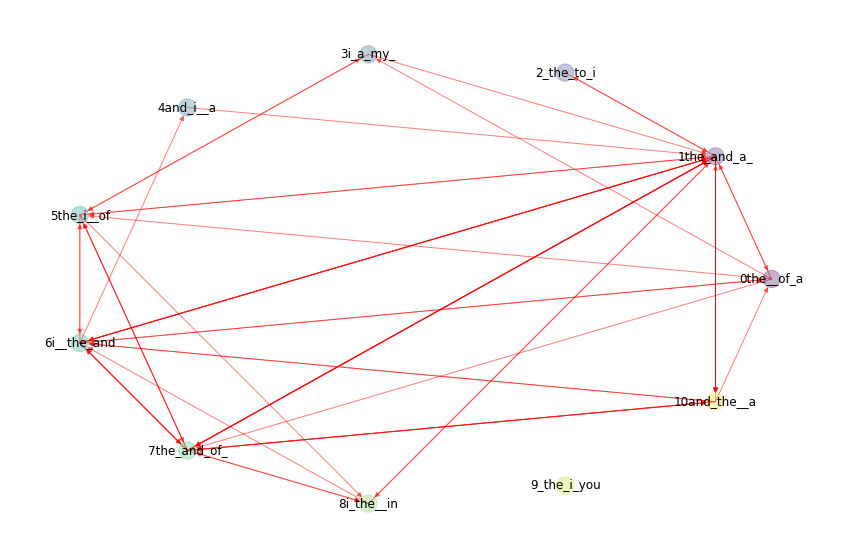

In [363]:
G = nx.DiGraph()

# nodes
for i in range(lda.num_topics):
    G.add_node(i)
for i in edge_list:
    G.add_edge(i[0], i[1])

# pos = nx.spring_layout(G)
pos = nx.circular_layout(G)

nx.draw_networkx_nodes(G,
                    pos,
                    nodelist=node_list,
                    node_color=nodecolor,
                    alpha=0.3)

nx.draw_networkx_edges(G, pos,
                       edgelist=edge_list,
                       width=1, alpha=0.5, edge_color='r')

nx.draw_networkx_labels(G, pos, 
                        labels=labels, font_size=12)

plt.rcParams['figure.figsize'] = [15, 10]
plt.axis('off')
plt.show()

### Exercise 05
- Review the methods for calculating how well model with a given number of topics fits the corpus
- LSA calculate energy spectrum loss
- LDA calculate perplexity for a document sample
- Calculate the LDA for a chat sample
- Plot the graph for the chat sample